# Explore: DUC Analytica Data

**GOAL:**
Analyze the data
1. Summarize the Data by looking at the data structure and the data distributions
2. Vizualize the data by looking at the attribute histograms and pairwise scatterplots of different attributes

## Imports
Import the necessary packages and their use cases for this project:

> pandas: data frames and data manipulation  
> numpy: summary statistics  
> matplotlib: used for visualizations  
> seasborn: fancy visualizations    
> pprint: Provides a capability to “pretty-print” arbitrary Python data structures in a form which can be used as input to the interpreter

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
from acquire_prepare import acquire_oil
from acquire_prepare import prep_data
import numpy as np
import pandas as pd

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import sys # used in command to make entire array print by default

# Feature Selection
# import xgboost as xgb
# from sklearn.decomposition import PCA

In [2]:
'''
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
'''

'\n%%javascript\nIPython.OutputArea.prototype._should_scroll = function(lines) {\n    return false;\n}\n'

In [3]:
# makes entire array print by default, 
# can add [:##] to end to set length
np.set_printoptions(threshold=sys.maxsize)

In [4]:
df = acquire_oil()
df = prep_data(df)

# Summarize Data

In [5]:
def nulls_by_col(df):
    num_missing = df.isnull().sum()
    rows = df.shape[0]
    pct_missing = num_missing/rows
    cols_missing = pd.DataFrame({'num_rows_missing': num_missing, 'pct_rows_missing': pct_missing})
    return cols_missing

def nulls_by_row(df):
    num_cols_missing = df.isnull().sum(axis=1)
    pct_cols_missing = df.isnull().sum(axis=1)/df.shape[1]*100
    rows_missing = pd.DataFrame({'num_cols_missing': num_cols_missing, 'pct_cols_missing': pct_cols_missing}).reset_index().groupby(['num_cols_missing','pct_cols_missing']).count().rename(index=str, columns={'index': 'num_rows'}).reset_index()
    return rows_missing


def df_summary(df):
    print('--- Shape: {}'.format(df.shape))
    print('--- Info')
    df.info()
    print('--- Descriptions')
    print(df.describe(include='all'))
    print('--- Nulls By Column')
    print(nulls_by_col(df))
    print('--- Nulls By Row')
    print(nulls_by_row(df))
    print('---Unique Rows')
    print (df.apply(lambda x: x.nunique()))

In [6]:
df_summary(df)

--- Shape: (9318, 37)
--- Info
<class 'pandas.core.frame.DataFrame'>
Index: 9318 entries, 8 to 19495
Data columns (total 37 columns):
api14                 9318 non-null int64
lease_name            9318 non-null object
well_number           9318 non-null object
county                9318 non-null object
type                  9318 non-null category
status                9318 non-null category
oper                  9318 non-null object
multi_well_lease      9318 non-null object
major_phase           9318 non-null category
formation             9318 non-null object
proppant_ppf          9318 non-null float64
prod_method           9318 non-null category
frac_fluid_gpf        9318 non-null float64
lateral_len           9318 non-null float64
frac_stages           9013 non-null float64
frac_fluid_type       9318 non-null object
first_prod            9318 non-null datetime64[ns]
last_prod             9318 non-null datetime64[ns]
oil_gravity           9157 non-null float64
peak_boepd           

### Data Information

In [7]:
df.describe()

,api14,proppant_ppf,frac_fluid_gpf,lateral_len,frac_stages,oil_gravity,peak_boepd,oil_hist,gas_hist,gor_hist,...,sur_long,well_id,mid_point_lat,mid_point_long,recovery,recovery_per_foot,months_active,recovery_per_month,vintage,vintage_bin
count,9.318000e+03,9318.000000,9318.000000,9318.000000,9013.000000,9157.000000,9318.000000,9318.000000,9318.000000,9318.000000,...,9318.000000,9318.000000,9318.000000,9318.000000,9318.000000,9318.000000,9318.000000,9318.000000,9318.000000,9318.000000
mean,4.222787e+13,1120.775660,1134.230122,5572.600451,3.295684,2.936702,547.623217,130.078540,423.864372,3866.755179,...,-102.214128,140465.327967,31.681871,-102.214267,168.854025,39.431410,59.759068,inf,2011.984331,4.500644
std,9.673161e+11,662.625628,719.381084,2820.094969,9.307234,11.690998,463.087660,100.236967,455.589992,3801.477774,...,0.896106,17782.856587,0.447557,0.896057,157.659551,59.513777,56.434354,NaN,7.646433,0.746319
min,3.000528e+13,1.098097,0.266553,4.000000,0.000000,0.000000,0.663017,0.031000,0.001000,0.212134,...,-104.340924,89050.000000,30.447167,-104.340768,0.013000,0.002991,0.000000,0.590909,1958.000000,1.000000
25%,4.222733e+13,504.009285,459.038726,4024.000000,0.000000,0.000000,196.561352,52.082000,125.579750,1434.608765,...,-103.009033,142652.250000,31.352079,-103.009261,65.673086,15.093743,33.000000,1244.383688,2012.000000,4.000000
50%,4.232934e+13,1154.738585,1205.672910,5105.000000,0.000000,0.000000,466.202550,112.977000,301.740500,2454.931515,...,-101.963287,146439.500000,31.645176,-101.963321,134.786759,24.505041,50.000000,2862.594477,2014.000000,5.000000
75%,4.238933e+13,1569.682102,1645.217257,7623.000000,0.000000,0.000000,784.419337,186.062750,570.071250,4838.140885,...,-101.488681,150584.750000,31.947362,-101.487952,210.069840,42.200800,66.000000,5289.013383,2015.000000,5.000000
max,4.250137e+13,3969.384520,2997.736330,13581.000000,70.000000,68.000000,7926.821290,754.662000,4692.163000,19968.130000,...,-100.689460,157516.000000,33.709741,-100.691821,999.305470,997.824074,726.000000,inf,2018.000000,5.000000


## Visualize Data: Hypothesis Visualization

Text(0, 0.5, 'Recovery')

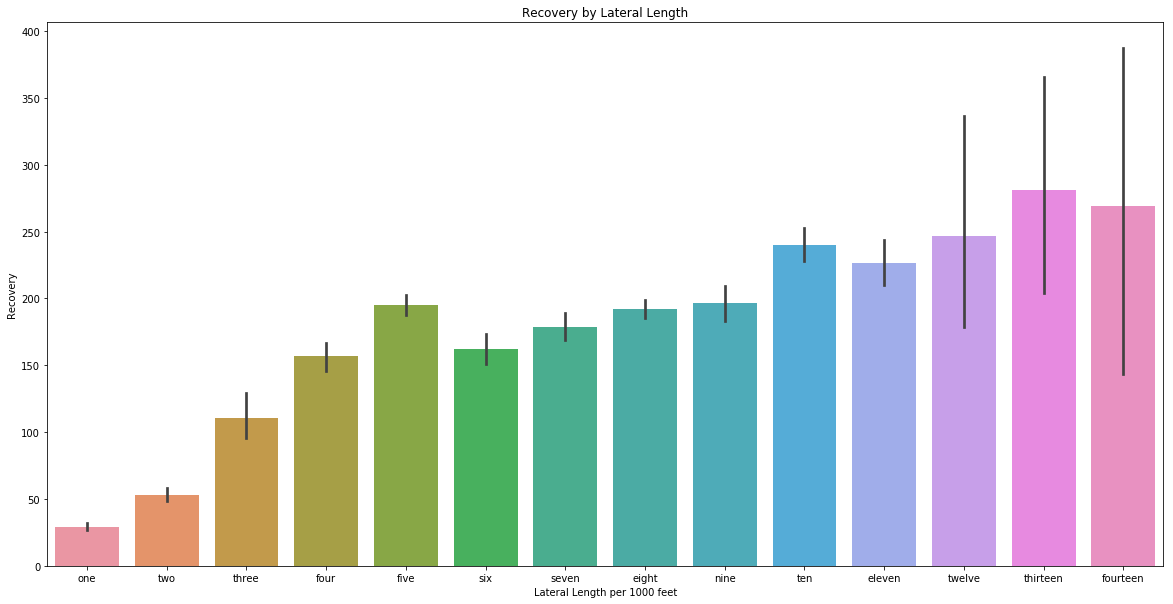

In [8]:
plt.figure(figsize=(20,10))
sns.barplot(x='lateral_class', y='recovery', data=df)

plt.title('Recovery by Lateral Length')
plt.xlabel('Lateral Length per 1000 feet')
plt.ylabel('Recovery')

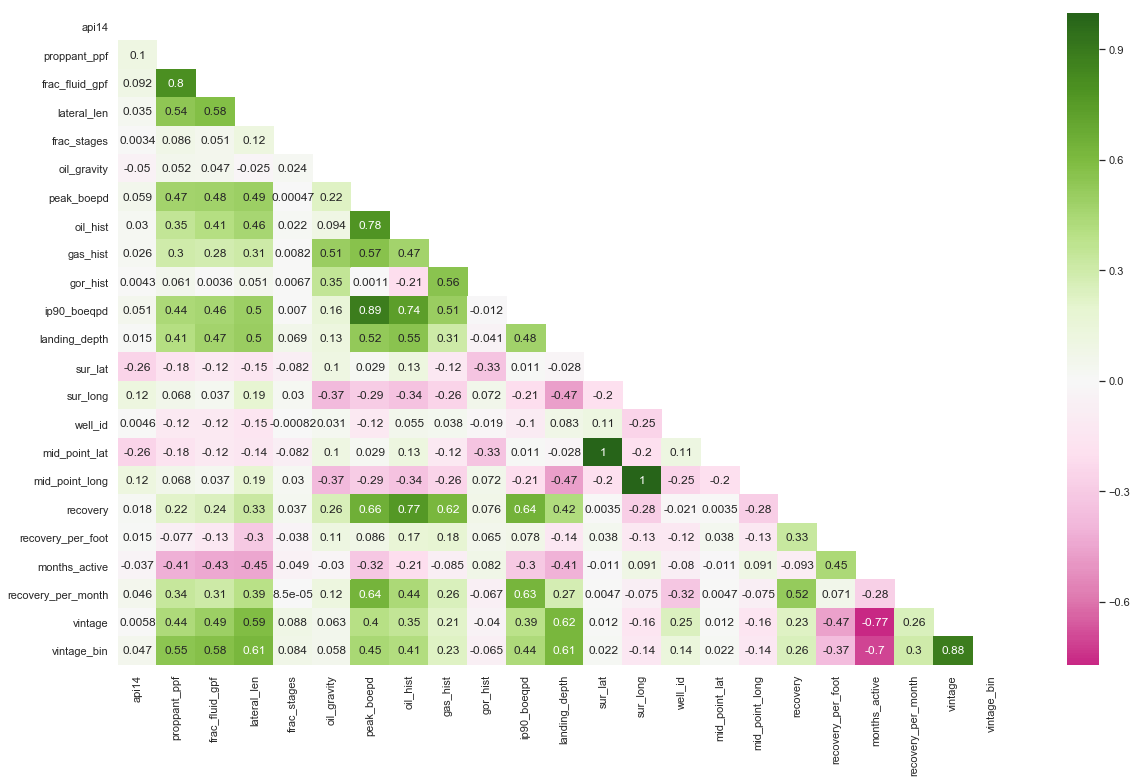

In [12]:
sns.set(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap='PiYG', annot=True, center=0)

### Attribute Histograms

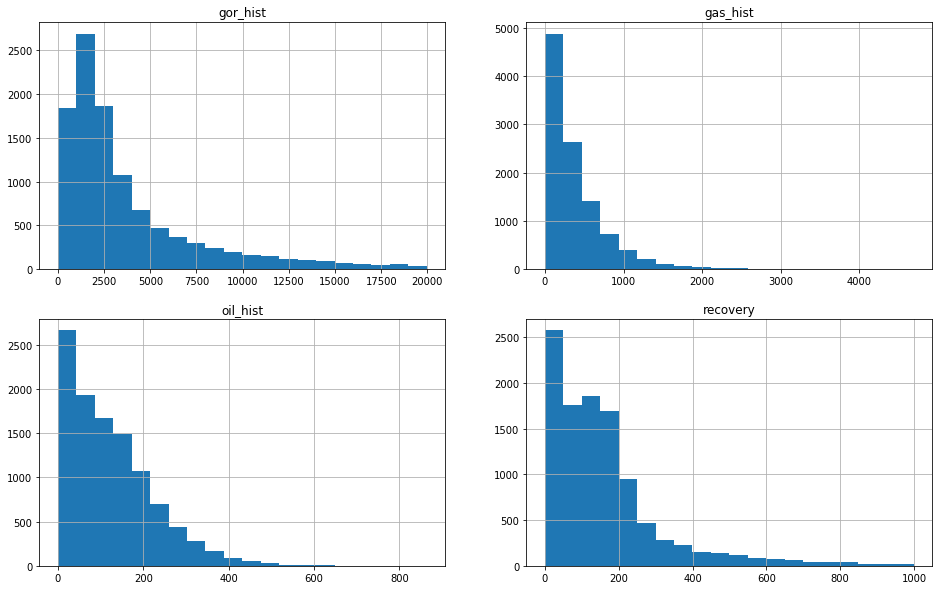

In [30]:
plt.figure(figsize=(16, 10))

for i, col in enumerate(['gor_hist', 'gas_hist', 'oil_hist', 'recovery']):  
    plot_number = i + 1 # i starts at 0, but plot nos should start at 1
    series = df[col]  
    plt.subplot(2, 2, plot_number)
    plt.title(col)
    series.hist(bins=20)

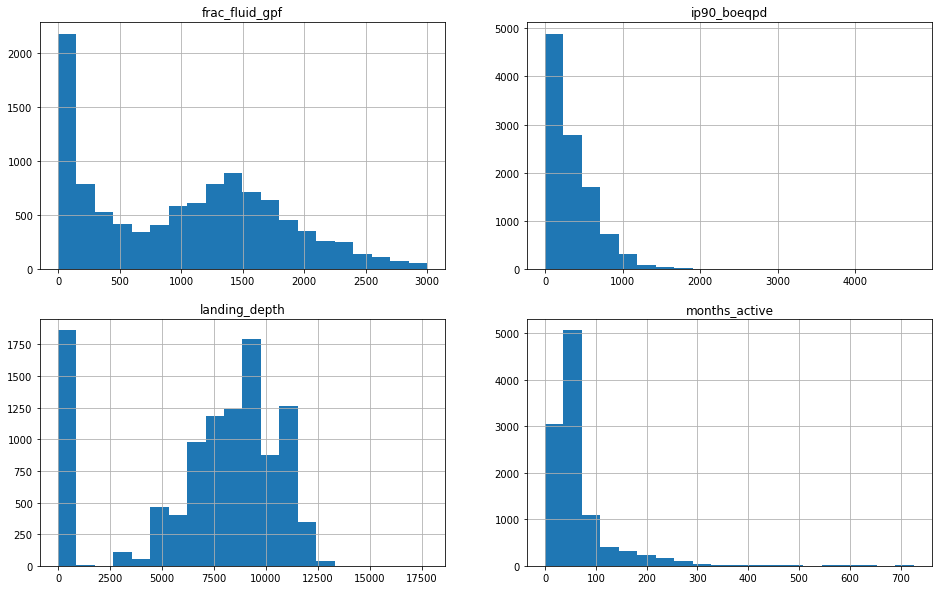

In [31]:
plt.figure(figsize=(16, 10))

for i, col in enumerate(['frac_fluid_gpf', 'ip90_boeqpd', 'landing_depth', 'months_active']):  
    plot_number = i + 1 # i starts at 0, but plot nos should start at 1
    series = df[col]  
    plt.subplot(2, 2, plot_number)
    plt.title(col)
    series.hist(bins=20)

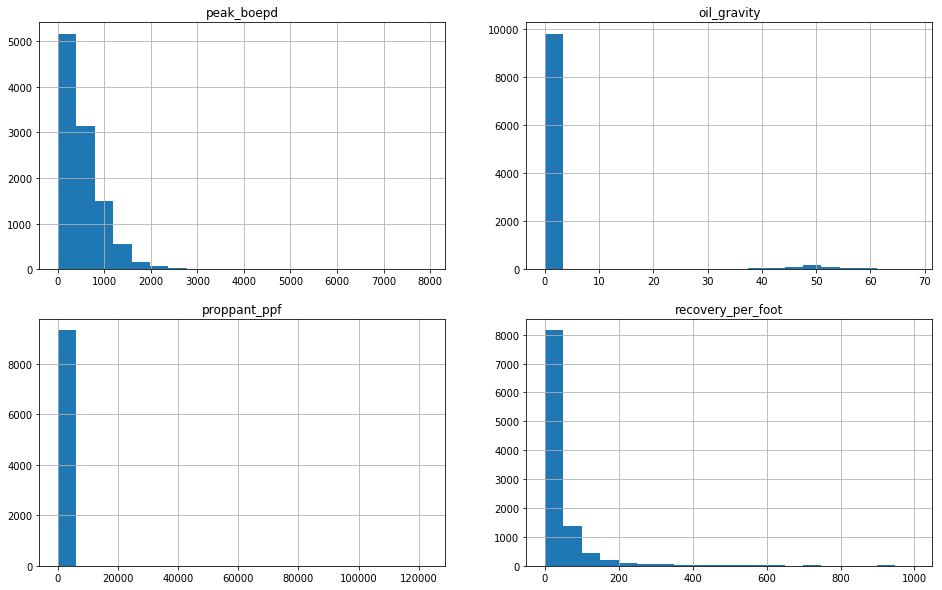

In [32]:
plt.figure(figsize=(16, 10))

for i, col in enumerate(['peak_boepd', 'oil_gravity', 'proppant_ppf', 'recovery_per_foot']):  
    plot_number = i + 1 # i starts at 0, but plot nos should start at 1
    series = df[col]  
    plt.subplot(2, 2, plot_number)
    plt.title(col)
    series.hist(bins=20)

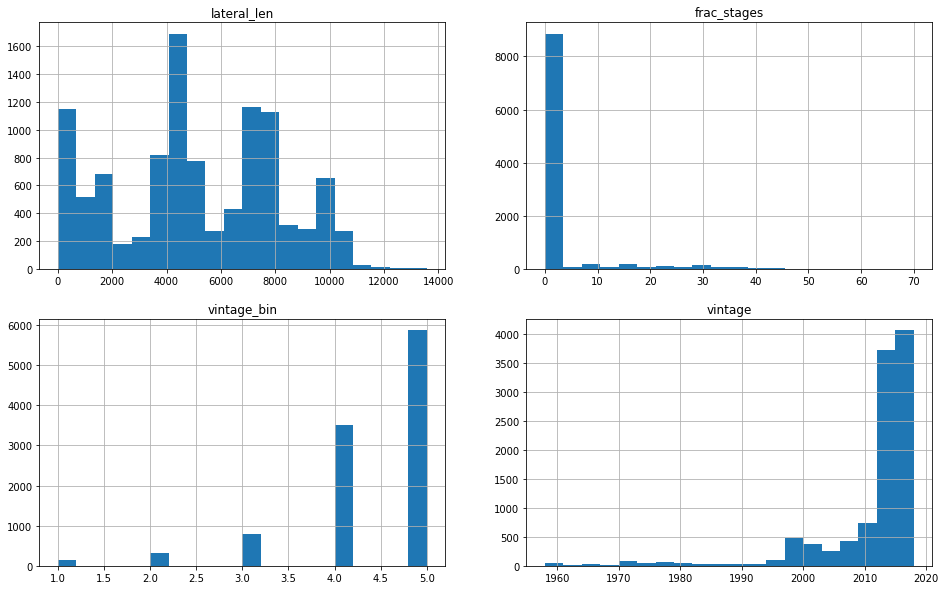

In [33]:
plt.figure(figsize=(16, 10))

for i, col in enumerate(['lateral_len', 'frac_stages', 'vintage_bin', 'vintage']):  
    plot_number = i + 1 # i starts at 0, but plot nos should start at 1
    series = df[col]  
    plt.subplot(2, 2, plot_number)
    plt.title(col)
    series.hist(bins=20)

### Pairwise Scatterplots

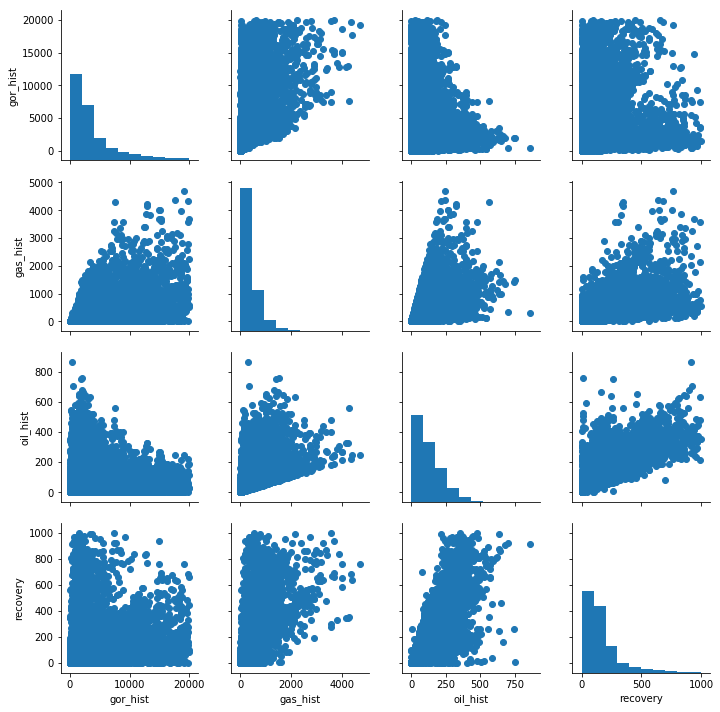

In [34]:
g = sns.PairGrid(df, vars=['gor_hist', 'gas_hist', 'oil_hist', 'recovery'])
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)

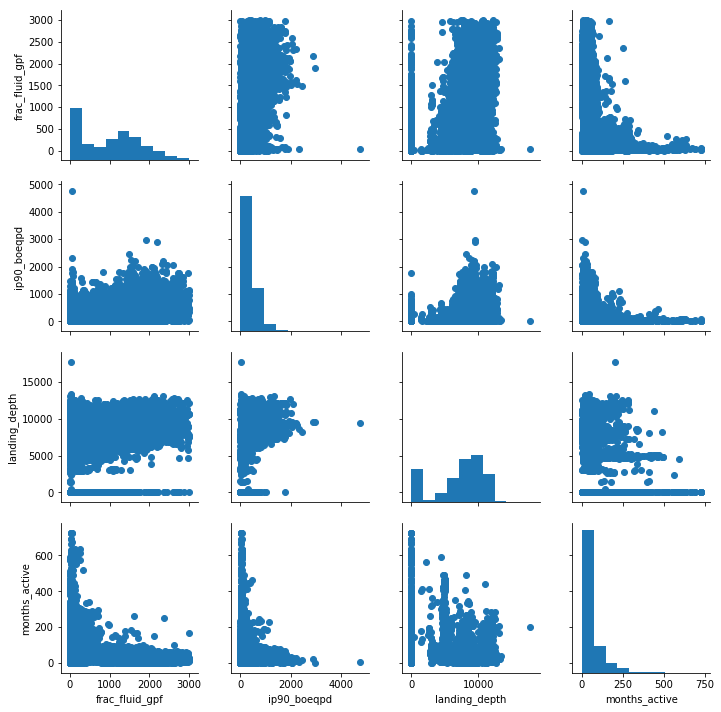

In [35]:
g = sns.PairGrid(df, vars=['frac_fluid_gpf', 'ip90_boeqpd', 'landing_depth', 'months_active'])
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)

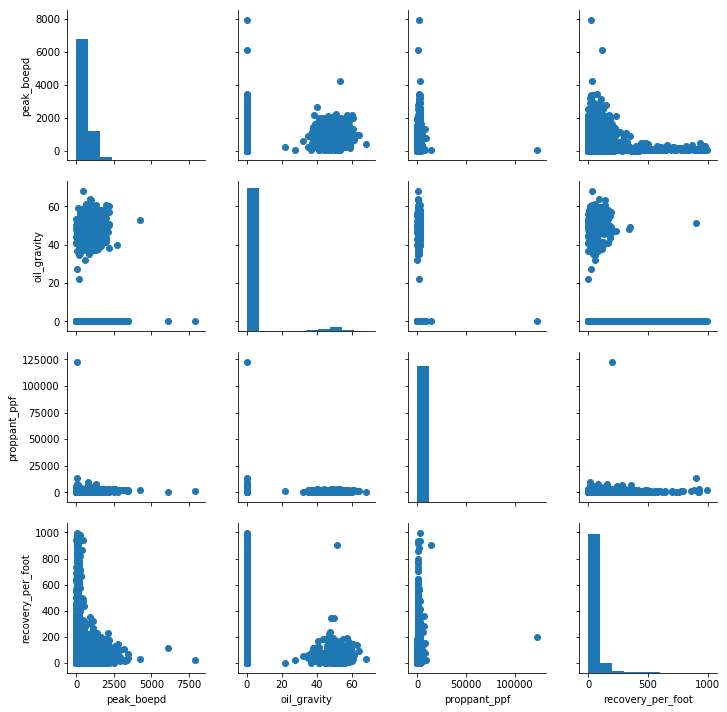

In [36]:
g = sns.PairGrid(df, vars=['peak_boepd', 'oil_gravity', 'proppant_ppf', 'recovery_per_foot'])
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)

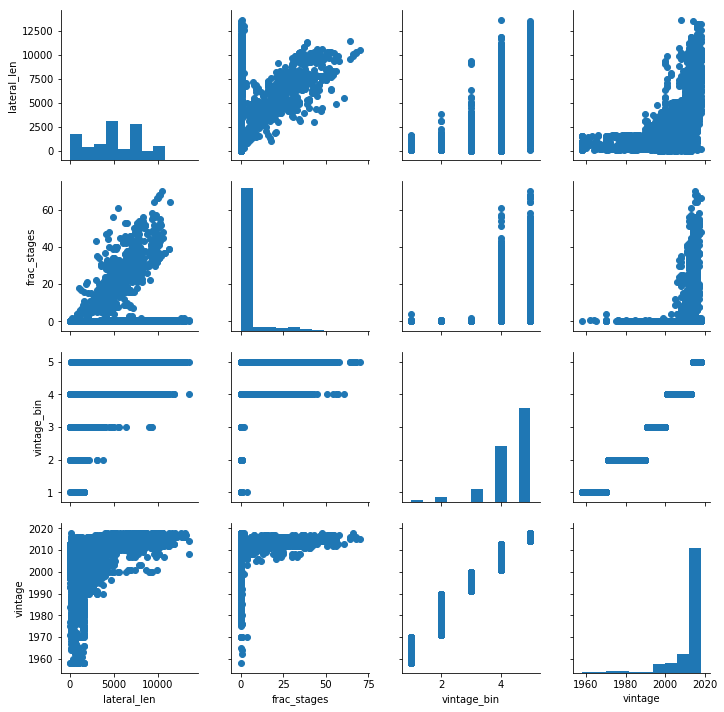

In [37]:
g = sns.PairGrid(df, vars=['lateral_len', 'frac_stages', 'vintage_bin', 'vintage'])
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)